In [2]:
!python -V
!export  LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/opt/root/lib:/home/xiaohl/.conda/envs/python38/lib/

Python 3.10.4


In [3]:
import sys
sys.path.append('..')
#import ROOT
from stixdcpy.quicklook import LightCurves
import numpy as np
import pandas as pd
import requests
import scipy 
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib notebook

In [4]:
lc=LightCurves.from_sdc(start_utc='2022-08-26T05:00:00', end_utc='2022-08-27T00:00:00', ltc=True)
#res.info()


<IPython.core.display.Javascript object>


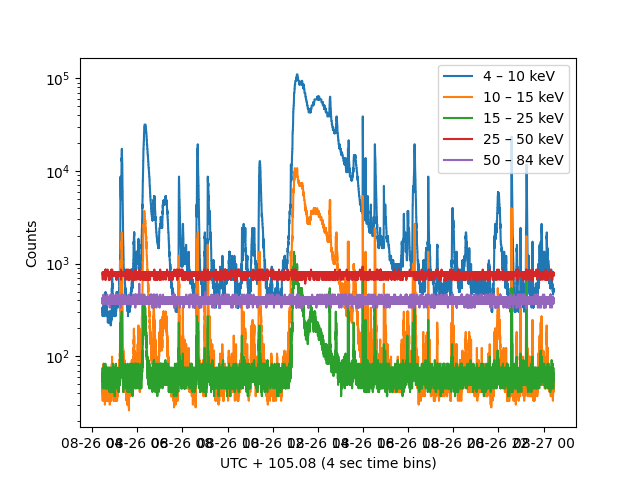

<AxesSubplot:xlabel='UTC + 105.08 (4 sec time bins)', ylabel='Counts'>

In [5]:
lc.peek()


In [6]:
lc0=lc.data['counts']['0']

In [7]:
s = pd.Series(lc0)

In [8]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
#Asymmetric Least Squares Smoothing
#https://stackoverflow.com/questions/29156532/python-baseline-correction-library
def baseline_als_optimized(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z


<IPython.core.display.Javascript object>


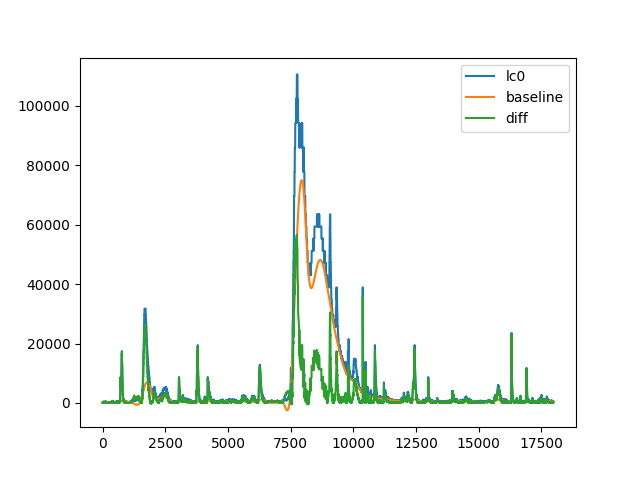

In [20]:
import peakutils
z = baseline_als_optimized(lc0, lam=1e5, p=1e-4)

fig=plt.figure()
plt.plot(lc0, label='lc0')
plt.plot(z, label='baseline')

plt.plot(lc0-z, label='diff')
plt.legend()
#plt.yscale('log')

<IPython.core.display.Javascript object>


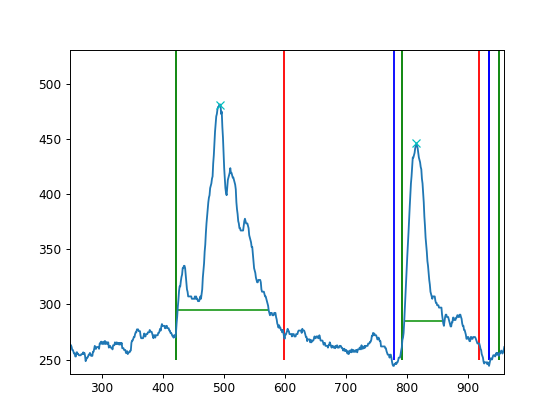

(array([ 86.84848485, 149.3       ,  63.52391304, 283.28      ,
       134.89285714,  68.3       ,  86.33333333,  13.25      ]), array([260.76      , 294.68      , 284.65333333, 262.89333333,
       266.73333333, 266.73333333, 266.30666667, 285.93333333]), array([  24.53333333,  424.65      ,  796.02608696,  992.16      ,
       1335.85714286, 1895.2       , 2136.6       , 2759.        ]), array([ 111.38181818,  573.95      ,  859.55      , 1275.44      ,
       1470.75      , 1963.5       , 2222.93333333, 2772.25      ])) {'peak_heights': array([296.6       , 481.13333333, 445.93333333, 330.73333333,
       305.13333333, 356.33333333, 332.86666667, 292.33333333]), 'prominences': array([ 44.8       , 233.06666667, 201.6       ,  84.8       ,
        48.        , 112.        ,  83.2       ,   8.        ]), 'left_bases': array([  16,  209,  779,  935, 1284,  935, 1988, 2710]), 'right_bases': array([ 209, 2710, 2710, 1809, 1809, 2710, 2710, 2773]), 'widths': array([ 96.33333333, 177.5625 

In [135]:
#plt.clf()

from scipy import signal 

roll=lambda a, n : np.convolve(a,np.ones(n,dtype='float')/n, 'same')[n//2:-n//2+1]  




fig = plt.figure()
ydata=roll(np.array(res.data['light_curves']['0']), 15)

xpeak,pro=signal.find_peaks(ydata, width=10, distance=200, height=280, rel_height=0.9)
half = signal.peak_widths(ydata, xpeak, rel_height=0.8)
print(half,pro)

plt.plot(ydata)
print(xpeak)
plt.plot(xpeak,ydata[xpeak],'x',color='c')
plt.vlines(pro['left_bases'], 250, 600,'b')
plt.vlines(pro['right_bases'], 250, 600,'b')
plt.vlines(pro['left_ips'], 250, 700,'g')
plt.vlines(pro['right_ips'], 250, 700, 'r')
plt.hlines(*half[1:], color="C2")

plt.show()

In [136]:

np.vstack((half[2],half[3])).T

array([[  24.53333333,  111.38181818],
       [ 424.65      ,  573.95      ],
       [ 796.02608696,  859.55      ],
       [ 992.16      , 1275.44      ],
       [1335.85714286, 1470.75      ],
       [1895.2       , 1963.5       ],
       [2136.6       , 2222.93333333],
       [2759.        , 2772.25      ]])

In [ ]:
def get_lightcurves(start, end):
    res= api.fetch(start,end,'lc',False)
    if not res:
        return None
    df= pd.DataFrame.from_records(res[1].data['COUNTS'])
    return df

In [ ]:
flare_df={}
margin_seconds=900
for fl in flare_data:
    start_unix=float(fl['start_unix_time'])
    duration=float(fl['duration'])
    start_dt=datetime.utcfromtimestamp(start_unix-margin_seconds)
    end_dt=datetime.utcfromtimestamp(start_unix+duration+margin_seconds)
    df=get_lightcurves(start_dt,end_dt)
    flare_df[fl['_id']]=df
    

In [ ]:
def find_peaks(df, fid,  lc_index=0):
    fig = plt.figure()
    ydata=df.loc[:,lc_index]
    xpeak,_=scipy.signal.find_peaks(ydata, width=10, distance=200)
    plt.plot(ydata)
    plt.title=f'flare:{fid}'
    plt.ylim(0.8*min(ydata),1.2*max(ydata))
    plt.vlines(xpeak,ydata[xpeak]*0.9, ydata[xpeak]*1.1, color='C1')#, 'x')
    plt.show()
    
for fid,df in flare_df.items():
    if df is not None:
        find_peaks(df, fid, lc_index=0)
    